# Exercise

## 0. Prerequisites

In [1]:
# import scripts from GitHub
!git clone https://github.com/yhs2773/PyTorch-for-Deep-Learning-Machine-Learning-Full-Course
!mv PyTorch-for-Deep-Learning-Machine-Learning-Full-Course/going_modular .
!mv PyTorch-for-Deep-Learning-Machine-Learning-Full-Course/helper_functions.py .
!rm -rf PyTorch-for-Deep-Learning-Machine-Learning-Full-Course

Cloning into 'PyTorch-for-Deep-Learning-Machine-Learning-Full-Course'...
remote: Enumerating objects: 354, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 354 (delta 76), reused 130 (delta 70), pack-reused 218
Receiving objects: 100% (354/354), 157.61 MiB | 36.46 MiB/s, done.
Resolving deltas: 100% (190/190), done.


In [ ]:
# install gradio
!pip -q install gradio

In [2]:
# load libraries
import torch
import torchvision

import matplotlib.pyplot as plt
import pathlib
import pandas as pd
import numpy as np

import gradio as gr

from torch import nn
from torchvision import transforms, models

from going_modular import data_setup, engine, predictions, utils
from helper_functions import download_data, set_seeds, plot_loss_curves

from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
from typing import Tuple, Dict
from timeit import default_timer as timer

In [3]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# get data
data_20 = download_data(source='https://github.com/yhs2773/PyTorch-for-Deep-Learning-Machine-Learning-Full-Course/raw/main/data/pizza_steak_sushi_20_percent.zip',
                        destination="pizza_steak_sushi_20_percent")

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/yhs2773/PyTorch-for-Deep-Learning-Machine-Learning-Full-Course/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [ ]:
# set directories
train_dir = data_20 / "train"
test_dir = data_20 / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [ ]:
# create model function
def create_model(num_classes: int=3,
                 seed: int=42,
                 is_effnetb2: bool=True):
    if is_effnetb2:
        weights = models.EfficientNet_B2_Weights.DEFAULT
        transforms = weights.transforms()
        model = models.efficientnet_b2(weights=weights)

        for param in model.parameters():
            param.requires_grad = False

        torch.manual_seed(seed)
        model.classifier = nn.Sequential(
            nn.Dropout(0.3, inplace=True),
            nn.Linear(in_features=1408, out_features=num_classes)
        )
    else:
        weights = models.ViT_B_16_Weights.DEFAULT
        transforms = weights.transforms()
        model = models.vit_b_16(weights=weights)

        for param in model.parameters():
            param.requires_grad = False

        torch.manual_seed(seed)
        model.heads = nn.Sequential(
            nn.Linear(in_features=768,
                      out_features=num_classes)
        )

    return model, transforms

In [ ]:
# EffNetB2 model
effnetb2, effnetb2_transforms = create_model(num_classes=3,
                                             seed=42,
                                             is_effnetb2=True)

In [ ]:
# ViT model
vit, vit_transforms = create_model(num_classes=3,
                                   seed=42,
                                   is_effnetb2=False)

In [ ]:
# create EffNetB2 dataloaders
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=effnetb2_transforms,
    batch_size=32
)

In [ ]:
# create ViT dataloaders
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=32
)

## 1. Make and time predictions with both feature extractor models on the test dataset using the GPU (`device="cuda"`). Compare the model's prediction times on GPU vs CPU - does this close the gap between them? As in, does making predictions on the GPU make the ViT feature extractor prediction times closer to the EffNetB2 feature extractor prediction times?
- You'll find code to do these steps in [section 5. Making predictions with our trained models and timing them](https://www.learnpytorch.io/09_pytorch_model_deployment/#5-making-predictions-with-our-trained-models-and-timing-them) and [section 6. Comparing model results, prediction times and size](https://www.learnpytorch.io/09_pytorch_model_deployment/#6-comparing-model-results-prediction-times-and-size).

In [ ]:
# optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

# loss function
loss_fn = torch.nn.CrossEntropyLoss()

# set seeds and train EffNetB2 model
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                epochs=10,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.9839 | Train acc: 0.5667 | Test loss: 0.7393 | Test acc: 0.9409
Epoch: 1 | Train loss: 0.7135 | Train acc: 0.8396 | Test loss: 0.5862 | Test acc: 0.9409
Epoch: 2 | Train loss: 0.5874 | Train acc: 0.8958 | Test loss: 0.4891 | Test acc: 0.9563
Epoch: 3 | Train loss: 0.4488 | Train acc: 0.9146 | Test loss: 0.4338 | Test acc: 0.9409
Epoch: 4 | Train loss: 0.4277 | Train acc: 0.9125 | Test loss: 0.3907 | Test acc: 0.9443
Epoch: 5 | Train loss: 0.4392 | Train acc: 0.8896 | Test loss: 0.3525 | Test acc: 0.9688
Epoch: 6 | Train loss: 0.4246 | Train acc: 0.8771 | Test loss: 0.3263 | Test acc: 0.9563
Epoch: 7 | Train loss: 0.3885 | Train acc: 0.8979 | Test loss: 0.3465 | Test acc: 0.9443
Epoch: 8 | Train loss: 0.3795 | Train acc: 0.8812 | Test loss: 0.3127 | Test acc: 0.9193
Epoch: 9 | Train loss: 0.3752 | Train acc: 0.8688 | Test loss: 0.2811 | Test acc: 0.9625


In [ ]:
# optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)

# loss function
loss_fn = torch.nn.CrossEntropyLoss()

# set seeds and train ViT model
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           loss_fn=loss_fn,
                           optimizer=optimizer,
                           epochs=10,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.7020 | Train acc: 0.7521 | Test loss: 0.2714 | Test acc: 0.9381
Epoch: 1 | Train loss: 0.2532 | Train acc: 0.9062 | Test loss: 0.1672 | Test acc: 0.9602
Epoch: 2 | Train loss: 0.1764 | Train acc: 0.9542 | Test loss: 0.1273 | Test acc: 0.9693
Epoch: 3 | Train loss: 0.1276 | Train acc: 0.9625 | Test loss: 0.1074 | Test acc: 0.9722
Epoch: 4 | Train loss: 0.1159 | Train acc: 0.9646 | Test loss: 0.0953 | Test acc: 0.9784
Epoch: 5 | Train loss: 0.1274 | Train acc: 0.9375 | Test loss: 0.0832 | Test acc: 0.9722
Epoch: 6 | Train loss: 0.0897 | Train acc: 0.9771 | Test loss: 0.0845 | Test acc: 0.9784
Epoch: 7 | Train loss: 0.0919 | Train acc: 0.9812 | Test loss: 0.0764 | Test acc: 0.9722
Epoch: 8 | Train loss: 0.0922 | Train acc: 0.9792 | Test loss: 0.0734 | Test acc: 0.9784
Epoch: 9 | Train loss: 0.0658 | Train acc: 0.9833 | Test loss: 0.0644 | Test acc: 0.9847


In [ ]:
# save models
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="pretrained_effnetb2_3_cls.pth")

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="pretrained_vit_3_cls.pth")

[INFO] Saving model to: models/pretrained_effnetb2_3_cls.pth
[INFO] Saving model to: models/pretrained_vit_3_cls.pth


In [ ]:
# get the model size
effnetb2_model_size = Path("models/pretrained_effnetb2_3_cls.pth").stat().st_size // (1024**2)
vit_model_size = Path("models/pretrained_vit_3_cls.pth").stat().st_size // (1024**2)

In [ ]:
# count the num of params in the models
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
vit_total_params = sum(torch.numel(param) for param in vit.parameters())

In [ ]:
# get model stats
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "num_params": effnetb2_total_params,
                  "model_size (MB)": effnetb2_model_size}

vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "num_params": vit_total_params,
             "model_size (MB)": vit_model_size}

In [ ]:
# get test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

In [ ]:
# GPU model results
effnetb2_results_gpu = predictions.pred_and_store(paths=test_data_paths,
                                                  model=effnetb2,
                                                  transform=effnetb2_transforms,
                                                  class_names=class_names,
                                                  device="cuda")

vit_results_gpu = predictions.pred_and_store(paths=test_data_paths,
                                             model=vit,
                                             transform=vit_transforms,
                                             class_names=class_names,
                                             device="cuda")

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# create a dataframe
effnetb2_results_gpu_df = pd.DataFrame(effnetb2_results_gpu)
vit_results_gpu_df = pd.DataFrame(vit_results_gpu)

In [ ]:
# calculate the average time for prediction
effnetb2_gpu_average_time = round(effnetb2_results_gpu_df.time_for_pred.mean(), 4)
vit_gpu_average_time = round(vit_results_gpu_df.time_for_pred.mean(), 4)

In [ ]:
# add it to the dataframe
effnetb2_results_gpu_df['time_per_pred_gpu'] = effnetb2_gpu_average_time
vit_results_gpu_df['time_per_pred_gpu'] = vit_gpu_average_time

In [ ]:
# CPU model results
effnetb2_results_cpu = predictions.pred_and_store(paths=test_data_paths,
                                                  model=effnetb2,
                                                  transform=effnetb2_transforms,
                                                  class_names=class_names,
                                                  device="cpu")

vit_results_cpu = predictions.pred_and_store(paths=test_data_paths,
                                             model=vit,
                                             transform=vit_transforms,
                                             class_names=class_names,
                                             device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
# create a dataframe
effnetb2_results_cpu_df = pd.DataFrame(effnetb2_results_cpu)
vit_results_cpu_df = pd.DataFrame(vit_results_cpu)

In [ ]:
# calculate the average time for prediction
effnetb2_cpu_average_time = round(effnetb2_results_cpu_df.time_for_pred.mean(), 4)
vit_cpu_average_time = round(vit_results_cpu_df.time_for_pred.mean(), 4)

In [ ]:
# add it to the dataframe
effnetb2_results_cpu_df['time_per_pred_cpu'] = effnetb2_cpu_average_time
vit_results_cpu_df['time_per_pred_cpu'] = vit_cpu_average_time

In [ ]:
# add average prediction time of the models
effnetb2_stats['time_per_pred_gpu'] = effnetb2_gpu_average_time
effnetb2_stats['time_per_pred_cpu'] = effnetb2_cpu_average_time
vit_stats['time_per_pred_gpu'] = vit_gpu_average_time
vit_stats['time_per_pred_cpu'] = vit_cpu_average_time

In [ ]:
# create a stats dataframe
df = pd.DataFrame([effnetb2_stats, vit_stats])

# add/update columns
df["model"] = ["EffNetB2", "ViT"]
df["test_acc"] = round(df["test_acc"] * 100, 2)
df["GPU vs CPU"] = round(df['time_per_pred_cpu'] / df['time_per_pred_gpu'], 2)

df

,test_loss,test_acc,num_params,model_size (MB),time_per_pred_gpu,time_per_pred_cpu,model,GPU vs CPU
0,0.281087,96.25,7705221,29,0.0247,0.1139,EffNetB2,4.61
1,0.064435,98.47,85800963,327,0.0238,0.4298,ViT,18.06


As seen in the last column of the dataframe, EffNetB2 on GPU is **4.61x** faster and ViT on GPU is **18.06x** faster than CPU models

## 2. The ViT feature extractor seems to have more learning capacity (due to more parameters) than EffNetB2, how does it go on the larger 20% split of the entire Food101 dataset?
- Train a ViT feature extractor on the 20% Food101 dataset for 5 epochs, just like we did with EffNetB2 in [section 10. Creating FoodVision Big](https://www.learnpytorch.io/09_pytorch_model_deployment/#10-creating-foodvision-big).


In [ ]:
# create a model corresponding to the data labels
vit_food101, vit_transforms = create_model(num_classes=101,
                                           is_effnetb2=False)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [03:23<00:00, 1.71MB/s]


In [ ]:
# add augmentation to vit_transforms
food101_train_transforms_vit = transforms.Compose([
    transforms.TrivialAugmentWide(),
    vit_transforms
])

In [ ]:
# get Food101 dataset
train_food101 = torchvision.datasets.Food101(root='data',
                                             split='train',
                                             transform=food101_train_transforms_vit,
                                             download=True)

test_food101 = torchvision.datasets.Food101(root='data',
                                            split='test',
                                            transform=vit_transforms,
                                            download=True)

food101_class_names = train_food101.classes

100%|██████████| 4996278331/4996278331 [00:54<00:00, 92056807.22it/s] 


Extracting data/food-101.tar.gz to data


In [ ]:
# get 20% from Food101 dataset
train_food101_20, _ = torch.utils.data.random_split(dataset=train_food101,
                                                    lengths=[0.2, 0.8],
                                                    generator=torch.manual_seed(42))

test_food101_20, _ = torch.utils.data.random_split(dataset=test_food101,
                                                   lengths=[0.2, 0.8],
                                                   generator=torch.manual_seed(42))

len(train_food101_20), len(test_food101_20)

(15150, 5050)

In [ ]:
# create dataloaders
train_dataloader_food101_20 = torch.utils.data.DataLoader(dataset=train_food101_20,
                                                          batch_size=32,
                                                          shuffle=True)

test_dataloader_food101_20 = torch.utils.data.DataLoader(dataset=test_food101_20,
                                                         batch_size=32,
                                                         shuffle=False)

In [ ]:
# set loss fn and optimizer
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=vit_food101.parameters(),
                             lr=1e-3)

# train the model
set_seeds()
vit_food101_20_results = engine.train(model=vit_food101,
                                      train_dataloader=train_dataloader_food101_20,
                                      test_dataloader=test_dataloader_food101_20,
                                      loss_fn=loss_fn,
                                      optimizer=optimizer,
                                      epochs=5,
                                      device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 2.4848 | Train acc: 0.4262 | Test loss: 1.4780 | Test acc: 0.6219
Epoch: 1 | Train loss: 1.6517 | Train acc: 0.5881 | Test loss: 1.2627 | Test acc: 0.6627
Epoch: 2 | Train loss: 1.4425 | Train acc: 0.6326 | Test loss: 1.1785 | Test acc: 0.6834
Epoch: 3 | Train loss: 1.2982 | Train acc: 0.6691 | Test loss: 1.1405 | Test acc: 0.6886
Epoch: 4 | Train loss: 1.2281 | Train acc: 0.6912 | Test loss: 1.0983 | Test acc: 0.7037


EfficientNetB2's 5 epoch results were
```
Epoch: 0 | Train loss: 3.6422 | Train acc: 0.2795 | Test loss: 2.7824 | Test acc: 0.4903
Epoch: 1 | Train loss: 2.8626 | Train acc: 0.4410 | Test loss: 2.4729 | Test acc: 0.5334
Epoch: 2 | Train loss: 2.6559 | Train acc: 0.4866 | Test loss: 2.3633 | Test acc: 0.5556
Epoch: 3 | Train loss: 2.5455 | Train acc: 0.5124 | Test loss: 2.3022 | Test acc: 0.5751
Epoch: 4 | Train loss: 2.4963 | Train acc: 0.5235 | Test loss: 2.2799 | Test acc: 0.5810
```
And ViT B-16's 5 epoch results are
```
Epoch: 0 | Train loss: 2.4848 | Train acc: 0.4262 | Test loss: 1.4780 | Test acc: 0.6219
Epoch: 1 | Train loss: 1.6517 | Train acc: 0.5881 | Test loss: 1.2627 | Test acc: 0.6627
Epoch: 2 | Train loss: 1.4425 | Train acc: 0.6326 | Test loss: 1.1785 | Test acc: 0.6834
Epoch: 3 | Train loss: 1.2982 | Train acc: 0.6691 | Test loss: 1.1405 | Test acc: 0.6886
Epoch: 4 | Train loss: 1.2281 | Train acc: 0.6912 | Test loss: 1.0983 | Test acc: 0.7037
```
With more learning capacity, ViT is clearly showing better results than EffNetB2 in both loss and accuracy

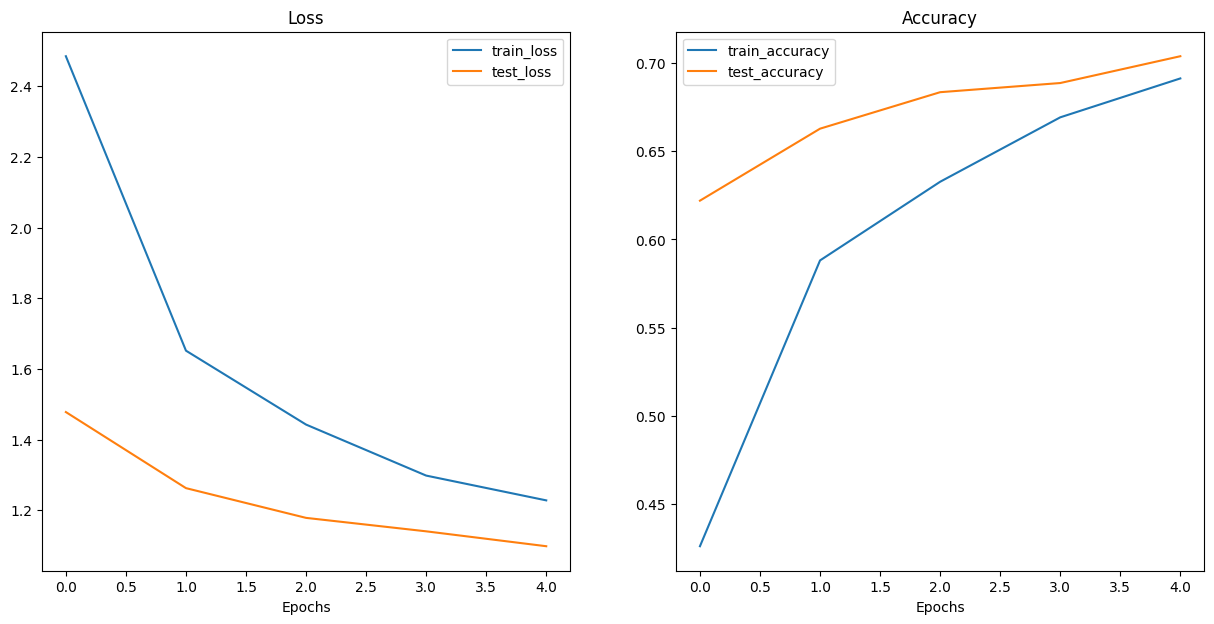

In [ ]:
plot_loss_curves(vit_food101_20_results)

## 3. Make predictions across the 20% Food101 test dataset with the ViT feature extractor from exercise 2 and find the "most wrong" predictions.
- The predictions will be the ones with the highest prediction probability but with the wrong predicted label.
- Write a sentence or two about why you think the model got these predictions wrong.

In [ ]:
# create a test_dataloader with batch_size 1 since just inferencing
test_dataloader_food101_20_bs_1 = torch.utils.data.DataLoader(dataset=test_food101_20,
                                                              batch_size=1,
                                                              shuffle=False)

In [ ]:
# make predictions
vit_food101_pred_list = []

# put model into a device
vit_food101 = vit_food101.to(device)

# change to eval mode
vit_food101.eval()

for X, y in tqdm(test_dataloader_food101_20_bs_1):

    pred_dict = {}

    X, y = X.to(device), y.to(device)

    with torch.inference_mode():
        pred_probs = torch.softmax(vit_food101(X), dim=1)
        pred_label = torch.argmax(pred_probs, dim=1)

        # adding `.max()` here, otherwise you get a list of all probs of 101 classes
        pred_dict['pred_probs'] = pred_probs.max().cpu().numpy().item()
        pred_dict['pred_label'] = pred_label.cpu().numpy().item()
        pred_dict['true_label'] = y.cpu().numpy().item()

    vit_food101_pred_list.append(pred_dict)

  0%|          | 0/5050 [00:00<?, ?it/s]

In [ ]:
# turn it into a dataframe
vit_food101_pred_df = pd.DataFrame(vit_food101_pred_list)

In [ ]:
# create various columns
vit_food101_pred_df['correct'] = vit_food101_pred_df['pred_label'] == vit_food101_pred_df['true_label']
vit_food101_pred_df['pred_class'] = vit_food101_pred_df['pred_label'].apply(lambda x: food101_class_names[x])
vit_food101_pred_df['true_class'] = vit_food101_pred_df['true_label'].apply(lambda x: food101_class_names[x])

In [ ]:
vit_food101_pred_df

,pred_probs,pred_label,true_label,correct,pred_class,true_class
0,0.926865,72,72,True,pancakes,pancakes
1,0.942099,57,57,True,hummus,hummus
2,0.248790,36,80,False,falafel,pulled_pork_sandwich
3,0.566604,51,51,True,guacamole,guacamole
4,0.925756,1,1,True,baby_back_ribs,baby_back_ribs
...,...,...,...,...,...,...
5045,0.631740,29,29,True,cup_cakes,cup_cakes
5046,0.435744,26,26,True,crab_cakes,crab_cakes
5047,0.986189,78,78,True,poutine,poutine
5048,0.383556,87,87,True,scallops,scallops


In [ ]:
# count the number of correct & incorrect
vit_food101_pred_df['correct'].value_counts()

True     3554
False    1496
Name: correct, dtype: int64

In [ ]:
# see only False and sort values by probabilities
vit_food101_pred_df[vit_food101_pred_df['correct'] == False].sort_values(by='pred_probs', ascending=False).head(10)

,pred_probs,pred_label,true_label,correct,pred_class,true_class
2287,0.993240,38,28,False,fish_and_chips,croque_madame
3107,0.990636,52,32,False,gyoza,dumplings
2848,0.984569,41,8,False,french_onion_soup,bread_pudding
3157,0.963439,3,30,False,beef_carpaccio,deviled_eggs
4969,0.953115,28,56,False,croque_madame,huevos_rancheros
1306,0.945971,71,44,False,paella,fried_rice
36,0.934327,86,95,False,sashimi,sushi
3436,0.930636,45,58,False,frozen_yogurt,ice_cream
1185,0.928769,12,6,False,cannoli,beignets
230,0.912927,36,78,False,falafel,poutine


Going through the 10 wrong cases with the highest probabilities, I can see that there are some classes that could be hard to differenciate (e.g. gyoza vs dumpling), but there are some classes that shouldn't be hard to differenciate (e.g. fish and chips vs croque madame)

## 4. Evaluate the ViT feature extractor across the whole Food101 test dataset rather than just the 20% version, how does it perform?
- Does it beat the original Food101 paper's best result of 56.4% accuracy?

In [ ]:
# dataloader for the whole dataset
train_dataloader_food101 = torch.utils.data.DataLoader(dataset=train_food101,
                                                       batch_size=32,
                                                       shuffle=True)

test_dataloader_food101 = torch.utils.data.DataLoader(dataset=test_food101,
                                                      batch_size=32,
                                                      shuffle=False)

In [ ]:
# train on Food101 dataset with already trained model on 20% of Food101 data
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.Adam(params=vit_food101.parameters(),
                             lr=1e-3)

set_seeds()
vit_food101_results = engine.train(model=vit_food101,
                                   train_dataloader=train_dataloader_food101,
                                   test_dataloader=test_dataloader_food101,
                                   loss_fn=loss_fn,
                                   optimizer=optimizer,
                                   epochs=5,
                                   device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 2.0937 | Train acc: 0.6408 | Test loss: 1.7205 | Test acc: 0.7409
Epoch: 1 | Train loss: 1.9847 | Train acc: 0.6702 | Test loss: 1.6996 | Test acc: 0.7496
Epoch: 2 | Train loss: 1.9474 | Train acc: 0.6829 | Test loss: 1.6786 | Test acc: 0.7567
Epoch: 3 | Train loss: 1.9254 | Train acc: 0.6904 | Test loss: 1.6748 | Test acc: 0.7570
Epoch: 4 | Train loss: 1.9150 | Train acc: 0.6924 | Test loss: 1.6764 | Test acc: 0.7599


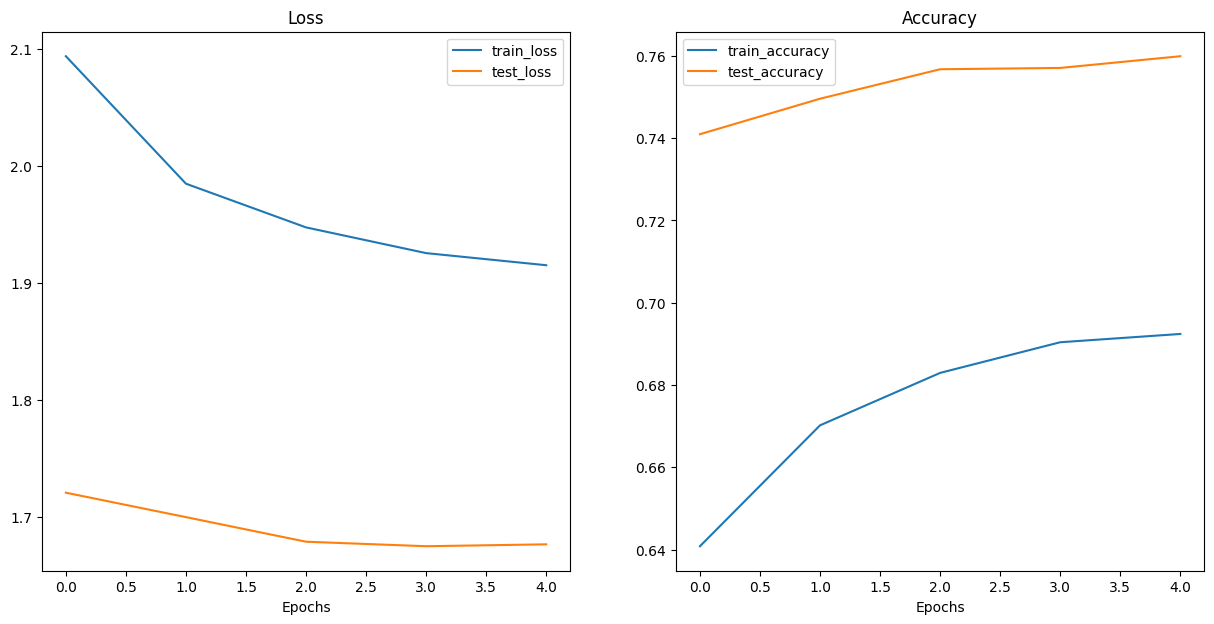

In [ ]:
# plot curves
plot_loss_curves(vit_food101_results)

In [ ]:
# re-initialize the pre-trained model's weights
vit_food101, vit_transforms = create_model(num_classes=101,
                                           is_effnetb2=False)

In [ ]:
# train on Food101 dataset
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.Adam(params=vit_food101.parameters(),
                             lr=1e-3)

set_seeds()
vit_food101_results = engine.train(model=vit_food101,
                                   train_dataloader=train_dataloader_food101,
                                   test_dataloader=test_dataloader_food101,
                                   loss_fn=loss_fn,
                                   optimizer=optimizer,
                                   epochs=5,
                                   device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 2.3441 | Train acc: 0.5597 | Test loss: 1.7624 | Test acc: 0.7266
Epoch: 1 | Train loss: 2.0367 | Train acc: 0.6508 | Test loss: 1.7129 | Test acc: 0.7440
Epoch: 2 | Train loss: 1.9739 | Train acc: 0.6726 | Test loss: 1.6831 | Test acc: 0.7545
Epoch: 3 | Train loss: 1.9418 | Train acc: 0.6846 | Test loss: 1.6757 | Test acc: 0.7565
Epoch: 4 | Train loss: 1.9263 | Train acc: 0.6878 | Test loss: 1.6763 | Test acc: 0.7584


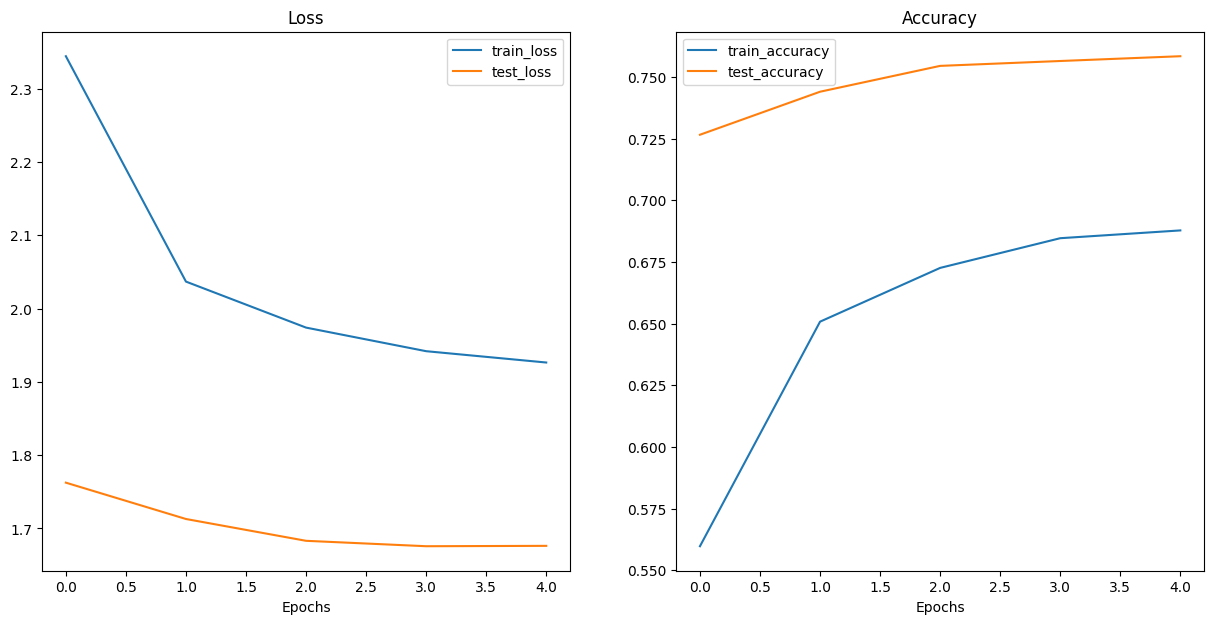

In [ ]:
# plot curves
plot_loss_curves(vit_food101_results)

So I've done two things:
1. In question 2, I've trained ViT on a 20% of the Food101 dataset and I've used that model to train on a complete Food101 dataset and the results are:
```
Epoch: 0 | Train loss: 2.0937 | Train acc: 0.6408 | Test loss: 1.7205 | Test acc: 0.7409
Epoch: 1 | Train loss: 1.9847 | Train acc: 0.6702 | Test loss: 1.6996 | Test acc: 0.7496
Epoch: 2 | Train loss: 1.9474 | Train acc: 0.6829 | Test loss: 1.6786 | Test acc: 0.7567
Epoch: 3 | Train loss: 1.9254 | Train acc: 0.6904 | Test loss: 1.6748 | Test acc: 0.7570
Epoch: 4 | Train loss: 1.9150 | Train acc: 0.6924 | Test loss: 1.6764 | Test acc: 0.7599
```
2. I've re-initialized weights (create a model instance again), since ViT was already trained on a 20% of Food101. I wanted to see the difference between two options and the results are:
```
Epoch: 0 | Train loss: 2.3441 | Train acc: 0.5597 | Test loss: 1.7624 | Test acc: 0.7266
Epoch: 1 | Train loss: 2.0367 | Train acc: 0.6508 | Test loss: 1.7129 | Test acc: 0.7440
Epoch: 2 | Train loss: 1.9739 | Train acc: 0.6726 | Test loss: 1.6831 | Test acc: 0.7545
Epoch: 3 | Train loss: 1.9418 | Train acc: 0.6846 | Test loss: 1.6757 | Test acc: 0.7565
Epoch: 4 | Train loss: 1.9263 | Train acc: 0.6878 | Test loss: 1.6763 | Test acc: 0.7584
```

It looks like re-initializing model weights doesn't make too much of a difference performance-wise. So re-initializing model weights would depend on the purpose. (e.g. if you wanted to load a pre-trained model and check the performance on your dataset)

## 5. Head to Paperswithcode.com and find the current best performing model on the Food101 dataset.
- What model architecture does it use?

There are 5 different tasks for the Food101 dataset:
- Fine-Grained Image Classification (Food-101)
    - Used EffNet-L2 (SAM)
- Image Classification (food101)
    - Used swin-finetuned-food101-e3
- Image Classification (Food-101)
    - Used Bamboo (ViTB/16)
- Neural Architecture Search (Food-101)
    - Used NAT-M4
- Image Classification (Food-101N)
    - Used LRA-diffusion (CLIP ViT)

## 6. Write down 1-3 potential failure points of our deployed FoodVision models and what some potential solutions might be.
- For example, what happens if someone was to upload a photo that wasn't of food to our FoodVision Mini model?

1. As mentioned in bullet points, when a photo is not in a category of Food101 categories. The image will then be classified as another/similar food type based on probs (i.e. scallops can be classified as poached eggs)
    - Possible solution is to have more specific categories (i.e. increase the number of classes) or train more data so it can classify better
2. Similar food can be classified into any of similar food categories
    - Possible solution would be to minimize the categories (i.e. dumplings and gyoza can be put together as dumplings category)
3. When a photo is not a food at all, it will still classify as one of the food (e.g. car can be classified as any of the food in Food101 classes)
    - Possible solution is to apply OOD (out of distribution) (i.e. anomaly detection) or OSR (Open-set recognition), so the image that is not food can be classified as error/unknown/wrong

## 7. Pick any dataset from [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) and train a feature extractor model on it using a model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) (you could use one of the model's we've already created, e.g. EffNetB2 or ViT) for 5 epochs and then deploy your model as a Gradio app to Hugging Face Spaces.
- You may want to pick smaller dataset/make a smaller split of it so training doesn't take too long.
- I'd love to see your deployed models! So be sure to share them in Discord or on the [course GitHub Discussions page](https://github.com/mrdbourke/pytorch-deep-learning/discussions).

In [ ]:
# list available models
all_models = torchvision.models.list_models()
all_models

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcn_resnet101',
 'fcn_resnet50',
 'fcos_resnet50_fpn',
 'googlenet',
 'inception_v3',
 'keypointrcnn_resnet50_fpn',
 'lraspp_mobilenet_v3_large',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'maxvit_t',
 'mc3_18',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mvit_v1_b',
 'mvit_v2_s',
 'quantized_googlenet',
 '

In [4]:
# instance of model and weight
regnet_weights = torchvision.models.RegNet_Y_128GF_Weights.DEFAULT
regnet_transforms = regnet_weights.transforms()
regnet = torchvision.models.regnet_y_128gf(weights=regnet_weights)

Downloading: "https://download.pytorch.org/models/regnet_y_128gf_swag-c8ce3e52.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_128gf_swag-c8ce3e52.pth
100%|██████████| 2.40G/2.40G [00:23<00:00, 110MB/s]


In [5]:
train_transforms = transforms.Compose([
    transforms.AutoAugment(),
    regnet_transforms
])

In [6]:
# get data
train_pet = torchvision.datasets.OxfordIIITPet(root='data',
                                               split='trainval',
                                               transform=train_transforms,
                                               download=True)

test_pet = torchvision.datasets.OxfordIIITPet(root='data',
                                              split='test',
                                              transform=regnet_transforms,
                                              download=True)

# get classes names
pet_class_names = train_pet.classes

pet_class_names, len(pet_class_names)

100%|██████████| 791918971/791918971 [01:11<00:00, 11124527.43it/s]


Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 10687701.44it/s]


Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


(['Abyssinian',
  'American Bulldog',
  'American Pit Bull Terrier',
  'Basset Hound',
  'Beagle',
  'Bengal',
  'Birman',
  'Bombay',
  'Boxer',
  'British Shorthair',
  'Chihuahua',
  'Egyptian Mau',
  'English Cocker Spaniel',
  'English Setter',
  'German Shorthaired',
  'Great Pyrenees',
  'Havanese',
  'Japanese Chin',
  'Keeshond',
  'Leonberger',
  'Maine Coon',
  'Miniature Pinscher',
  'Newfoundland',
  'Persian',
  'Pomeranian',
  'Pug',
  'Ragdoll',
  'Russian Blue',
  'Saint Bernard',
  'Samoyed',
  'Scottish Terrier',
  'Shiba Inu',
  'Siamese',
  'Sphynx',
  'Staffordshire Bull Terrier',
  'Wheaten Terrier',
  'Yorkshire Terrier'],
 37)

In [7]:
# dataset to dataloader
train_pet_dataloader = torch.utils.data.DataLoader(dataset=train_pet,
                                                   batch_size=32,
                                                   shuffle=True)

test_pet_dataloader = torch.utils.data.DataLoader(dataset=test_pet,
                                                  batch_size=32,
                                                  shuffle=False)

In [8]:
# check the model architecture
regnet

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 528, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(528, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(528, 528, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
      

In [9]:
# check model head/classifier/fc
regnet.fc

Linear(in_features=7392, out_features=1000, bias=True)

In [10]:
# freeze model feature extractor
for param in regnet.parameters():
    param.requires_grad = False

# modify the head
regnet.fc = nn.Linear(in_features = 7392, out_features = len(pet_class_names))

In [11]:
# loss fn & optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=regnet.parameters(),
                             lr=1e-3)

# train the model
regnet_results = engine.train(model=regnet,
                              train_dataloader=train_pet_dataloader,
                              test_dataloader=test_pet_dataloader,
                              loss_fn=loss_fn,
                              optimizer=optimizer,
                              epochs=5,
                              device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1364 | Train acc: 0.7111 | Test loss: 0.2025 | Test acc: 0.9389


KeyboardInterrupt: ignored

In [ ]:
# loss curve plot
plot_loss_curves(regnet_results)

In [ ]:
# save model
utils.save_model(model=regnet,
                 target_dir="models",
                 model_name="09_pretrained_regnet_feature_extractor_pet.pth")

In [ ]:
# function for prediction
def predict(img) -> Tuple[Dict, float]:
    # set timer
    start_time = timer()

    # transform image with model's transforms
    img = regnet_transforms(img).unsqueeze(0)

    # put model into eval mode and turn on infer mode
    regnet.eval()
    with torch.inference_mode():
        pred_probs = torch.softmax(regnet(img), dim=1)

    # dictionary comprehension to return prediction label and prediction probability
    pred_label_and_probs = {pet_class_names[i]: float(pred_probs[0][i]) for i in range(len(pet_class_names))}

    # calculate pred time
    pred_time = round(timer() - start_time, 4)

    # return the prediction dictionary and time
    return pred_label_and_probs, pred_time

In [16]:
# set directory
petvision_demo_path = Path("demos/petvision")

# create main directory
petvision_demo_path.mkdir(exist_ok = True, parents = True)

# create examples directory
(petvision_demo_path / "examples").mkdir(parents = True, exist_ok = True)

!ls demos/petvision/

examples


In [ ]:
# move model to demos folder
!mv models/09_pretrained_regnet_feature_extractor_pet.pth demos/petvision/

In [19]:
# download and move images to be used as examples
!wget https://github.com/yhs2773/PyTorch-for-Deep-Learning-Machine-Learning-Full-Course/blob/main/data/custom_images/pet_1.jpg?raw=true
!mv pet_1.jpg?raw=true demos/petvision/examples/pet_1.jpg
!wget https://github.com/yhs2773/PyTorch-for-Deep-Learning-Machine-Learning-Full-Course/blob/main/data/custom_images/pet_2.jpg?raw=true
!mv pet_2.jpg?raw=true demos/petvision/examples/pet_2.jpg
!wget https://github.com/yhs2773/PyTorch-for-Deep-Learning-Machine-Learning-Full-Course/blob/main/data/custom_images/pet_3.jpg?raw=true
!mv pet_3.jpg?raw=true demos/petvision/examples/pet_3.jpg
!wget https://github.com/yhs2773/PyTorch-for-Deep-Learning-Machine-Learning-Full-Course/blob/main/data/custom_images/pet_4.jpg?raw=true
!mv pet_4.jpg?raw=true demos/petvision/examples/pet_4.jpg
!wget https://github.com/yhs2773/PyTorch-for-Deep-Learning-Machine-Learning-Full-Course/blob/main/data/custom_images/pet_5.jpg?raw=true
!mv pet_5.jpg?raw=true demos/petvision/examples/pet_5.jpg

--2023-08-30 14:30:25--  https://github.com/yhs2773/PyTorch-for-Deep-Learning-Machine-Learning-Full-Course/blob/main/data/custom_images/pet_1.jpg?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/yhs2773/PyTorch-for-Deep-Learning-Machine-Learning-Full-Course/raw/main/data/custom_images/pet_1.jpg [following]
--2023-08-30 14:30:26--  https://github.com/yhs2773/PyTorch-for-Deep-Learning-Machine-Learning-Full-Course/raw/main/data/custom_images/pet_1.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yhs2773/PyTorch-for-Deep-Learning-Machine-Learning-Full-Course/main/data/custom_images/pet_1.jpg [following]
--2023-08-30 14:30:26--  https://raw.githubusercontent.com/yhs2773/PyTorch-for-Deep-Learning-Machine-Learning-Full-Course/main/data/custom